<a href="https://colab.research.google.com/github/cosminconstantincostea/RL_cosmincostea/blob/Reinforcement-Learning/v1_0_Baseline_vs_SAC_Training_difference_in_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
the main goal fo this file is to chek the difference between the two learning apporaches of a SAC agent with StableBaselines3 library and comparing them with respect to a baseline.

Environment used: CityLearn.
Goal: Minimize electricty consumption.



# Common

## Libraries and General Parameters

In [1]:
# TODO: update to install stable version from PyPi
!pip install --no-deps CityLearn==2.2b0
!pip install nrel-pysam

# Prove standard RL algorithms
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 3.2 MB/s eta 0:00:00


In [2]:
# import the necessary pacakages

# system operations
import inspect
import os
import uuid
import warnings

# date and time
import datetime

# type hinting
from typing import Any

# User interaction
from ipywidgets import Button, HTML
from ipywidgets import Text, HBox, VBox

# data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm import tqdm

# data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json

# cityLearn
from citylearn.agents.base import (
    BaselineAgent,
    Agent as RandomAgent
)
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import (
    NormalizedObservationWrapper,
    StableBaselines3Wrapper,
    TabularQLearningWrapper,
    DiscreteObservationWrapper,
    DiscreteActionWrapper
)

# RL algorithms
from stable_baselines3 import SAC
from stable_baselines3 import DQN
from stable_baselines3 import DDPG


# Callbacks
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold
from stable_baselines3.common.callbacks import BaseCallback

import time

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
# Global settings for the remainder of the note book

# All plotted figures without margins
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['axes.xmargin'] = 0
%matplotlib inline

# ignore depractino warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Dataset Initialization

Load the available data within the CityLean environment and display it.

In [4]:
display('All CityLearn datasets:', sorted(DataSet.get_names()))
DATASET_NAME = 'citylearn_challenge_2022_phase_1'

schema = DataSet.get_schema(DATASET_NAME)
root_directory = schema['root_directory']

'All CityLearn datasets:'

['baeda_3dem',
 'ca_alameda_county_neighborhood',
 'citylearn_challenge_2020_climate_zone_1',
 'citylearn_challenge_2020_climate_zone_2',
 'citylearn_challenge_2020_climate_zone_3',
 'citylearn_challenge_2020_climate_zone_4',
 'citylearn_challenge_2021',
 'citylearn_challenge_2022_phase_1',
 'citylearn_challenge_2022_phase_2',
 'citylearn_challenge_2022_phase_3',
 'citylearn_challenge_2022_phase_all',
 'citylearn_challenge_2023_phase_1',
 'citylearn_challenge_2023_phase_2_local_evaluation',
 'citylearn_challenge_2023_phase_2_online_evaluation_1',
 'citylearn_challenge_2023_phase_2_online_evaluation_2',
 'citylearn_challenge_2023_phase_2_online_evaluation_3',
 'citylearn_challenge_2023_phase_3_1',
 'citylearn_challenge_2023_phase_3_2',
 'citylearn_challenge_2023_phase_3_3',
 'tx_travis_county_neighborhood',
 'vt_chittenden_county_neighborhood']

### Environment Description
### Environment
<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/environment.jpg?raw=true"  width="800" alt="An overview of the heating, ventilation and air conditioning systems, energy storage systems, on-site electricity sources and grid interaction in buildings in the CityLearn environment." style="background-color:white;margin:20px;padding:5px">
  <figcaption>Figure: CityLearn building model including electricity sources that power controllable DERs including electric devices and ESSs, used to satisfy thermal and electrical loads as well as provide the grid with energy flexibility. A distinction is made between environment and control aspects of a building to show the transfer of actions from the control agent and reception of measurable observations by the control agent that quantifies the building's states (<a href="https://doi.org/10.48550/arXiv.2405.03848">Nweye et al., 2024</a>).</figcaption>
</figure>

CityLearn models a district of buildings with similar or different loads, electric devices, energy storage systems (ESSs) and electricity sources that satisfy the loads as shown in the figure above. There is no upper limit on the number of buildings in a district and a district can have as few as one building.

There are up to five loads ina building including:
- space cooling;
- space heating;
- domestic hot water (DHW) - all the hot water that a home needs;
- electric equipment - all the non-shiftable plug loads (lighting, entertainement, kitchen etc.);
- electric (EV) loads-

Building is modeled as single thermal zone where space thermal loads affect its indoor dry-bulb temperature. An occupant model has the ability to override the temperature setpoint.

Not all loads need to exist in a building.
Anyone or all of the loads are either known a priorii from building energy performance simulations (BEPS) or real-world measurements. In this instances the ideal load must be satisfied.
Alternatively, they are controlled loads and are inferred at runtime e.g., heat pump power control drives space cooling or heating loads.

To satisfy these loads in either the ideal or control-action case, CityLearn makes use of heating ventilation and air conditioning (HVAC) systems directly or ESSs through load shifting.
- The `cooling_device`, `heating_device`, and `dhw_device` are HVAC electric device objects in CityLearn that are used to satisfy the space cooling, space heating and DHW heating loads respectively.
- The `cooling_device` is a heat pump while the `heating_device` and `dhw_device` are either heat pump or electric heater type. These HVAC systems may be used to charge thermal energy storage (TES) systems in the building.


There are up to five optional and controlled ESSs in a building including:
TES Storages, DER type:
- `cooling_storage`;
- `heating_storage`;
- `dhw_storage`;

BESS - Battery energy storage system, DER type
- `electrical_storage`
- `electric_vehicle` - available on scheduel defined by its arrival and departure. The EV can be used in three modes:
  - G2V: Grid-to-Vehicle;
  - V2G: Vehicle-to-Grid;
  - No control: EV acts as load without any possibile control over its charging;

The electric devices are primarily powered by the electric grid. CityLearn at the time of writing, does not include a grid model so the power a building is able to draw from the grid at a given time step is unconstrained, except in the
case of a power outage.

Optionally, a building may have a photovoltaic (PV) system that provides self-generation as a first source of electricity before the grid. The optional `electrical_storage` and `electric_vehicle` are charged by the grid and PV but also augment the electricity supply when in discharge mode to supply the building with electricity. Excess self-generation, `electrical_storage`, and `electric_vehicle` discharge are sent to the grid as part of the building's net export.




### Control Variables
<table>
    <tr>
        <th>Name</th>
        <th><code>a</code> range</th>
        <th>Description</th>
    </tr>
    <tr>
        <td colspan="3"><strong>Energy storage system</strong></td>
    </tr>
    <tr>
        <td><code>cooling_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>cooling_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>heating_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>heating_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>dhw_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>dhw_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>electrical_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>electrical_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td><code>electric_vehicle_storage</code></td>
        <td>[-1, 1]</td>
        <td>Proportion of <code>electric_vehicle_storage</code> capacity to be charged (<code>a</code> > 0) or discharged (<code>a</code> < 0).</td>
    </tr>
    <tr>
        <td colspan="3"><strong>Electric device</strong></td>
    </tr>
    <tr>
        <td><code>cooling_device</code></td>
        <td>[0, 1]</td>
        <td>Proportion of space <code>cooling_device</code> nominal power to be supplied.</td>
    </tr>
    <tr>
        <td><code>heating_device</code></td>
        <td>[0, 1]</td>
        <td>Proportion of space <code>heating_device</code> nominal power to be supplied.</td>
    </tr>
</table>

The table above summarizes the continuous control action space in CityLearn where there are five ESS-related actions controlling the proportion of storage capacity to be charged or discharged and two HVAC electric device actions controlling the proportion of nominal power to be supplied. There are as many `electric_vehicle_storage` actions as there are EV chargers in a building.


<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/gymnasium_interface.jpg?raw=true"  width="200" alt="Farama Foundation Gymnasium interface." style="background-color:white;margin:20px;padding:5px">
  <figcaption>Figure: Farama Foundation Gymnasium interface (<a href="https://zenodo.org/records/10655021">Towers et al., 2023</a>).</figcaption>
</figure>

The CityLearn environment makes use of the Farama Foundation Gymnasium interface for standardized RLC environment design, where there is an observation-action-reward exchange loop between the environment and control agent as the environment transitions from one time step to another. In the current time step, $t$, the control agent receives the environment's observations, $o_t$ and prescribes actions $a_t$. The actions are applied to the environment to affect the observations at the next time step, $o_{t + 1}$. $o_{t + 1}$ and a reward, $r_{t + 1}$ (from reward function, $R$) that quantifies the quality of $a_t$ in optimizing the outcome of a control objective or KPI are returned to the control agent to teach it to learn a control policy, $\pi$. $\pi$ maps actions to observations that maximize the
cumulative reward over an episode i.e., the terminal state of the environment, after initialization ($t = 0$), beyond which there are new observations.

<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/control_architecture.jpg?raw=true"  width="600" alt="Single-agent (left), independent multi-agent (middle), and coordinated multi-agent (right) control configurations." style="background-color:white;margin:20px;padding:5px">
  <figcaption>Figure: Single-agent (left), independent multi-agent (middle), and coordinated multi-agent (right) control configurations (<a href="https://doi.org/10.48550/arXiv.2405.03848">Nweye et al., 2024</a>).</figcaption>
</figure>

There are three possible control configurations in CityLearn namely:
- **single-agent** - one-to-many relationship between the control agent and buildings where a centralized agent collects observations and prescribes actions for all DERs in the district and, receives a single reward value each time step to learn a generalized control policy. Akin to an energy aggregator.
- **independent multi-agent** - configuration has a one-to-one agent-building relationship thus, there are as many rewards as buildings each time step and a unique control policy is learned for each building. The coordinated multi-agent configuration is similar to the independent multi-agent configuration except that agents can share information to achieve cooperative objectives e.g. district peak reduction or competitive objectives e.g. price bidding in the energy flexibility market.
- **coordinated multi-agent**.

Preview

In [5]:
# change the suffix number in the next code line to a
# number between 1 and 17 to preview other buildings
building_name = 'Building_1'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
0,7,24,7,0,NaN,NaN,NaN,2.275800,0.0,0.0,0.0,0.0
1,8,1,1,0,NaN,NaN,NaN,0.851167,0.0,0.0,0.0,0.0
2,8,2,1,0,NaN,NaN,NaN,0.834600,0.0,0.0,0.0,0.0
3,8,3,1,0,NaN,NaN,NaN,0.838167,0.0,0.0,0.0,0.0
4,8,4,1,0,NaN,NaN,NaN,1.478433,0.0,0.0,0.0,0.0


In [6]:
display(building_data)

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
0,7,24,7,0,NaN,NaN,NaN,2.275800,0.0,0.0,0.0,0.000000
1,8,1,1,0,NaN,NaN,NaN,0.851167,0.0,0.0,0.0,0.000000
2,8,2,1,0,NaN,NaN,NaN,0.834600,0.0,0.0,0.0,0.000000
3,8,3,1,0,NaN,NaN,NaN,0.838167,0.0,0.0,0.0,0.000000
4,8,4,1,0,NaN,NaN,NaN,1.478433,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,7,19,1,0,NaN,NaN,NaN,1.346883,0.0,0.0,0.0,8.004167
8756,7,20,1,0,NaN,NaN,NaN,2.566167,0.0,0.0,0.0,0.000000
8757,7,21,1,0,NaN,NaN,NaN,3.151700,0.0,0.0,0.0,0.000000
8758,7,22,1,0,NaN,NaN,NaN,3.021500,0.0,0.0,0.0,0.000000


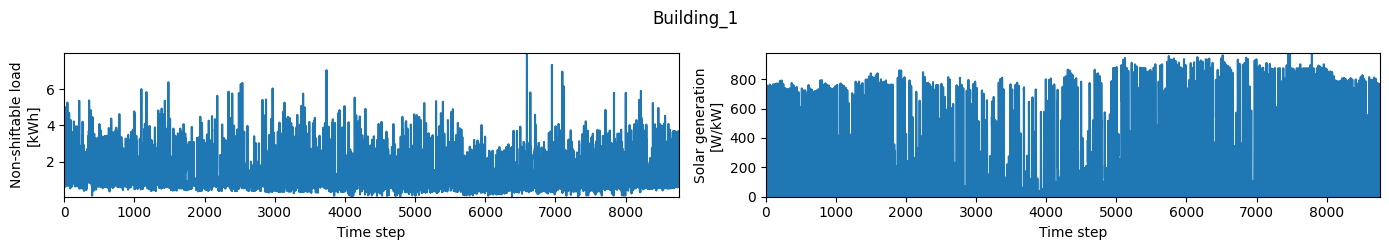

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 2.5))
x = building_data.index
y1 = building_data['non_shiftable_load']
y2 = building_data['solar_generation']
axs[0].plot(x, y1)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Non-shiftable load\n[kWh]')
axs[1].plot(x, y2)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Solar generation\n[W/kW]')
fig.suptitle(building_name)
plt.tight_layout()
plt.show()

Preview of the weather file


In [8]:
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
display(weather_data.head())


,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance,outdoor_dry_bulb_temperature_predicted_6h,outdoor_dry_bulb_temperature_predicted_12h,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0


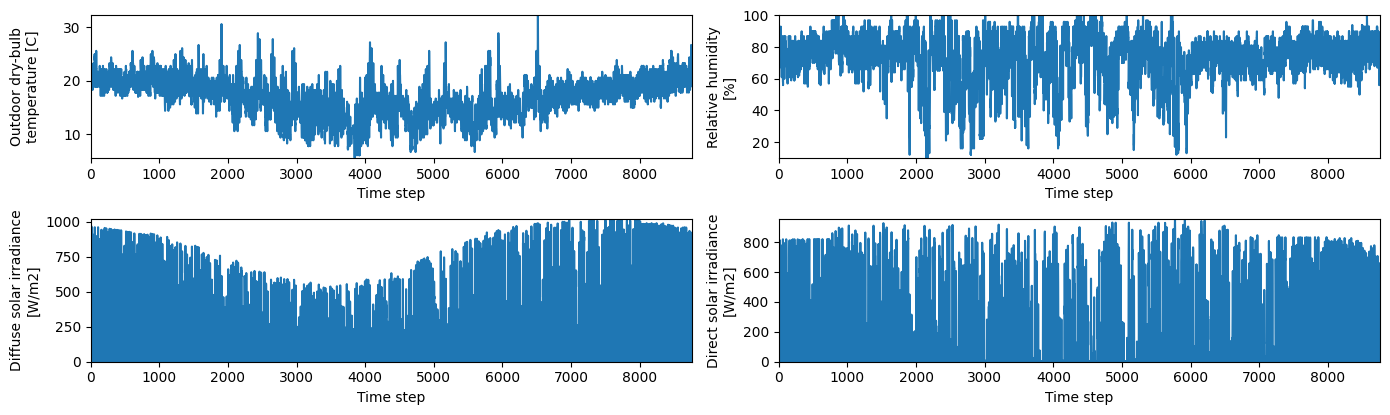

In [9]:
columns = [
    'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity',
    'diffuse_solar_irradiance', 'direct_solar_irradiance'
]
titles = [
    'Outdoor dry-bulb\ntemperature [C]', 'Relative humidity\n[%]',
    'Diffuse solar irradiance\n[W/m2]', 'Direct solar irradiance\n[W/m2]'
]
fig, axs = plt.subplots(2, 2, figsize=(14, 4.25))
x = weather_data.index

for ax, c, t in zip(fig.axes, columns, titles):
    y = weather_data[c]
    ax.plot(x, y)
    ax.set_xlabel('Time step')
    ax.set_ylabel(t)

fig.align_ylabels()
plt.tight_layout()
plt.show()

Preview of electricty price data

In [10]:
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
display(pricing_data.head())

,electricity_pricing,electricity_pricing_predicted_6h,electricity_pricing_predicted_12h,electricity_pricing_predicted_24h
0,0.22,0.22,0.22,0.22
1,0.22,0.22,0.22,0.22
2,0.22,0.22,0.22,0.22
3,0.22,0.22,0.22,0.22
4,0.22,0.22,0.54,0.22


### Random seed for reproducibility

In [11]:
RANDOM_SEED=42

## Data Preprocessing

Te main scope of this section to build functions for:
- Bulding selection subset from the main set;
- Simulation period selection from the main set;
- Observation to use in the simulations;
- Selection of the KPIs for the evaluation.


### Number of Building - Selection Function
Scope: choose between the available buildings in the data set. Only the defined number of buildings will be used to improve training speed and model evaluation. Building 12 and Building 15 will be excluded by default.

In [12]:
def select_buildings(
dataset_name: str, count: int, seed: int, buildings_to_exclude: list[str] = None,
) -> list[str]:
    """ Randoms elect buildings from Citylearn dataset.

    Parameters
    ----------
    dataset_name = str
        CityLearn dataset to query buildings from.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator
    building_to_exclude: list[str]
        List of buildings to exclude from selection pool

    Returns
    -------
    buildings: list[str]
    """

    assert 1 <= count <= 15, 'count must be between 1 and 15'

    # set random seed
    np.random.seed(seed)

    # get all bulding names
    schema = DataSet.get_schema(dataset_name)
    buildings = list(schema['buildings'].keys())

    # remove buildings 12 and 15 as they have peculiarities in thei data
    # that are no relevant for this application
    buildings_to_exclude = [] if buildings_to_exclude is None \
        else [b for b in buildings_to_exclude]
    buildings_to_exclude += ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        if b in buildings:
            buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, count, replace=False)

    return buildings.tolist()

### Simulation Period - Selection Function
Scope:
- Select a training period within the main dataset to train the agent;
- Select a testing period within the main dataset to test the agent on;

Currently the data is split in 70% training - 30% testing.



In [13]:
def select_simulation_period(
    dataset_name: str, count: int, seed: int,
    simulation_periods_to_exclude: list[tuple[int, int]] = None
) -> tuple[int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.
    simulation_periods_to_exclude: list[tuple[int, int]]
        List of simulation periods to exclude from selection pool.

    Returns
    -------
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """

    assert 1 <= count <= 365, 'count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total
    # number of available time steps
    schema = DataSet.get_schema(dataset_name)
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # exclude period if needed
    if simulation_periods_to_exclude is not None:
        simulation_start_time_step_list_to_exclude = \
            [s for s, e in simulation_periods_to_exclude]
        simulation_start_time_step_list = np.setdiff1d(
            simulation_start_time_step_list,
            simulation_start_time_step_list_to_exclude
        )

    else:
        pass

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    # Split for testing and training
    # 70% testing
    # 30% training
    training_days = int(count*0.7)
    print("Training days:", training_days)
    testing_days = int(count*0.3)
    print("Testing days:", testing_days)

    training_time_steps = training_days*24
    print("Training time steps:", training_time_steps)
    testing_time_steps = testing_days*24
    print("Testing time steps:", testing_time_steps)

    training_start_time_step = simulation_start_time_step
    training_end_time_step   = simulation_start_time_step + training_time_steps -1

    testing_start_time_step = training_end_time_step + 1
    testing_end_time_step   = testing_start_time_step + testing_time_steps -1

    return simulation_start_time_step, simulation_end_time_step,\
           training_start_time_step, training_end_time_step, \
           testing_start_time_step , testing_end_time_step



### Building, Time Period, Observation Selection and Agent type definition


In the following section the Number of buildings, the testing and training period and the observations used are selected.
Also the type of the agent that will operate in the environment is selected to be:
- Single agent;
- Indipendent multi-agent;
- Coordinated multi-agent.

In [14]:
BUILDING_COUNT = 3
BUILDINGS = select_buildings(
    DATASET_NAME,
    BUILDING_COUNT,
    RANDOM_SEED,
)
print('Selected building:', BUILDINGS)

DAY_COUNT = 21
SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP,\
TRAINING_START_TIME_STEP, TRAINING_END_TIME_STEP,\
TESTING_START_TIME_STEP, TESTING_END_TIME_STEP = select_simulation_period(
    DATASET_NAME,
    DAY_COUNT,
    RANDOM_SEED
)

EPISODE_TIME_STEPS = 24; # I choose to run it over 1 day for multiple periods

print(
    f'Selected {DAY_COUNT}-day simulation period:',
    (SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP)
)
print(
    f'Selected {DAY_COUNT*0.7}-day training period:',
    (TRAINING_START_TIME_STEP, TRAINING_END_TIME_STEP)
)
print(f'Selected {DAY_COUNT*0.3}-day testing period:',
    (TESTING_START_TIME_STEP, TESTING_END_TIME_STEP)
)

ACTIVE_OBSERVATIONS = ['hour']


# The control will be centralized: one agent will control al the buildings.
CENTRAL_AGENT = True

Selected building: ['Building_2', 'Building_5', 'Building_3']
Training days: 14
Testing days: 6
Training time steps: 336
Testing time steps: 144
Selected 21-day simulation period: (np.int64(3024), np.int64(3527))
Selected 14.7-day training period: (np.int64(3024), np.int64(3359))
Selected 6.3-day testing period: (np.int64(3360), np.int64(3503))


### Environment initialization check
Check if the CityLearn Env initialize correctly

In [15]:
# Environment initialization
env = CityLearnEnv(
    DATASET_NAME,
    central_agent = CENTRAL_AGENT,
    buildings = BUILDINGS,
    simulation_start_time_step = TRAINING_START_TIME_STEP,
    simulation_end_time_step = TRAINING_END_TIME_STEP,
    episode_time_steps = EPISODE_TIME_STEPS,
)

print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))

# Now let's calculate also the number of the episodes

first_valid_start = TRAINING_START_TIME_STEP
last_valid_start = TRAINING_END_TIME_STEP - EPISODE_TIME_STEPS

print('Simulation_start_time_step', TRAINING_START_TIME_STEP)
print('Simulation_end_time_step', TRAINING_END_TIME_STEP)
print('Last episode starts:',last_valid_start)

episodes = (last_valid_start - first_valid_start +1)/EPISODE_TIME_STEPS + 1
print('Episodes available:',episodes)

total_training_time_steps = TRAINING_END_TIME_STEP - TRAINING_START_TIME_STEP + 1
print('Total time steps:', total_training_time_steps)

episodes*EPISODE_TIME_STEPS

Current time step: 0
environment number of time steps: 24
environment uses central agent: True
Number of buildings: 3
Simulation_start_time_step 3024
Simulation_end_time_step 3359
Last episode starts: 3335
Episodes available: 14.0
Total time steps: 336


np.float64(336.0)

In [16]:
observations, _ = env.reset()
obs = observations[0]
obs_names = env.observation_names[0]

print(len(obs), len(obs_names))
obs_dict = dict(zip(obs_names, obs))

obs_dict,

36 36


({'month': np.int32(12),
  'day_type': np.int32(7),
  'hour': np.int32(24),
  'outdoor_dry_bulb_temperature': np.float32(14.4),
  'outdoor_dry_bulb_temperature_predicted_6h': np.float32(13.9),
  'outdoor_dry_bulb_temperature_predicted_12h': np.float32(18.3),
  'outdoor_dry_bulb_temperature_predicted_24h': np.float32(13.3),
  'outdoor_relative_humidity': np.float32(75.0),
  'outdoor_relative_humidity_predicted_6h': np.float32(72.0),
  'outdoor_relative_humidity_predicted_12h': np.float32(59.0),
  'outdoor_relative_humidity_predicted_24h': np.float32(83.0),
  'diffuse_solar_irradiance': np.float32(0.0),
  'diffuse_solar_irradiance_predicted_6h': np.float32(0.0),
  'diffuse_solar_irradiance_predicted_12h': np.float32(317.0),
  'diffuse_solar_irradiance_predicted_24h': np.float32(0.0),
  'direct_solar_irradiance': np.float32(0.0),
  'direct_solar_irradiance_predicted_6h': np.float32(0.0),
  'direct_solar_irradiance_predicted_12h': np.float32(8.0),
  'direct_solar_irradiance_predicted_24h':

In [17]:
print(len(obs_dict))

28


## Get KPIs for evaluations
n.5 KPIs are considered to measure how good the agent is performing:
1. electricity cost;
2. carbon emissions;
3. average daily peak;
4. ramping;
5. 1-load factor;

3 and 5 are District level KPIs


### Convenience functions to display simulation results
In the following some convenience function will be defined to plot the simulation results to confront different agents behaviour.


In [18]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """
    kpis = env.unwrapped.evaluate()

    """try:
        kpis = env.unwrapped.evaluate()
    except ZeroDivisionError:
        # Skip or insert a dummy KPI table
        kpis = pd.DataFrame(columns=['cost_function', 'value', 'level', 'name'])
    """

    # names of KPIs to retrieve from evaluate function
    kpi_names = {
        'cost_total': 'Cost',
        'carbon_emissions_total': 'Emissions',
        'daily_peak_average': 'Avg. daily peak',
        'ramping_average': 'Ramping',
        'monthly_one_minus_load_factor_average': '1 - load factor'
    }
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()
    kpis['cost_function'] = kpis['cost_function'].map(lambda x: kpi_names[x])

    # round up the values to 2 decimal places for readability
    kpis['value'] = kpis['value'].round(2)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    # Add epsilon to prevent division by zero in 1 - load factor calculation
    epsilon = 1e-9
    kpis.loc[kpis['kpi'] == '1 - load factor', 'value'] = kpis.loc[kpis['kpi'] == '1 - load factor', 'value'].apply(lambda x: x if x != 0 else epsilon)


    return kpis

#### Plot - Building KPI

In [19]:
def plot_building_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        for j, _ in enumerate(envs):
            ax.bar_label(ax.containers[j], fmt='%.2f')

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

    return fig

#### Plot - Disctrict KPI

In [20]:
def plot_district_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for j, _ in enumerate(envs):
        ax.bar_label(ax.containers[j], fmt='%.2f')

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

#### Plot - Building Load Profile

In [21]:
def plot_building_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots building-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.unwrapped.buildings[i].net_electricity_consumption
            y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_ylabel('kWh')

        if daily_average:
            ax.set_xlabel('Hour')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

        else:
            ax.set_xlabel('Time step')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

#### Plot - Distric Load Profile

In [22]:
def plot_district_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots district-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.unwrapped.net_electricity_consumption
        y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_ylabel('kWh')

    if daily_average:
        ax.set_xlabel('Hour')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

    else:
        ax.set_xlabel('Time step')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    plt.tight_layout()
    return fig

#### Plot - SOC profiles


In [23]:
def plot_battery_soc_profiles(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = np.array(v.unwrapped.buildings[i].electrical_storage.soc)
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
        ax.set_ylim(0.0, 1.0)

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

#### Plot - Simulation Summary

In [24]:
def plot_simulation_summary(envs: dict[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    print('#'*8 + ' BUILDING-LEVEL ' + '#'*8)
    print('Building-level KPIs:')
    _ = plot_building_kpis(envs)
    plt.show()

    print('Building-level simulation period load profiles:')
    _ = plot_building_load_profiles(envs)
    plt.show()

    print('Building-level daily-average load profiles:')
    _ = plot_building_load_profiles(envs, daily_average=True)
    plt.show()

    print('Battery SoC profiles:')
    _ = plot_battery_soc_profiles(envs)
    plt.show()

    print('#'*8 + ' DISTRICT-LEVEL ' + '#'*8)
    print('District-level KPIs:')
    _ = plot_district_kpis(envs)
    plt.show()

    print('District-level simulation period load profiles:')
    _ = plot_district_load_profiles(envs)
    plt.show()

    print('District-level daily-average load profiles:')
    _ = plot_district_load_profiles(envs, daily_average=True)
    plt.show()

#### Plot - Actions

In [25]:
def plot_actions(actions_list: list[list[float]], building_names: list[str], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: list[list[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    building_names: list[str]:
        List of build names that map to the action lists.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(6, 1))
    plot_data = pd.DataFrame(actions_list, columns=building_names)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24*7))
    ax.set_title(title)

    return fig

#### Plot - Rewards

In [26]:
def plot_rewards(ax: plt.Axes, rewards: list[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: list[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

## Baseline simulation
In the following cells the baseline for the environment will be simulated and plotted.

### Environment Creation


In [27]:
baseline_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TESTING_START_TIME_STEP,
    simulation_end_time_step=TESTING_END_TIME_STEP,
)


### Agent Definition

In [28]:
baseline_model = BaselineAgent(baseline_env)

/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


### Training

### Testing

In [30]:
# always start by reseting the environment
observations, _ = baseline_env.reset()
step_count = 0
# step through the environment until terminal
# state is reached i.e., the control episode ends
while not baseline_env.terminated:   # usare gli step qui e non "terminated"
    # select actions from the model
    actions = baseline_model.predict(observations)
    step_count = step_count + 1
    # if step_count%20 == 0:
      # print(actions)
      # print(observations)

    # apply selected actions to the environment
    observations, _, _, _, _ = baseline_env.step(actions)

# Note to self, the episode_count = episodes_time_steps - 1.
# The env run the test the number of timesteps set in the env.
# If you do not set the episode_timesteps, it will be automatically set to:
# SIMULATION_START_TIME_STEPS - SIMULATION_END_TIME_STEPS + 1
step_count

/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


143

### Plot Results

######## BUILDING-LEVEL ########
Building-level KPIs:


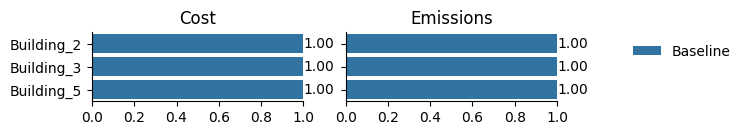

Building-level simulation period load profiles:


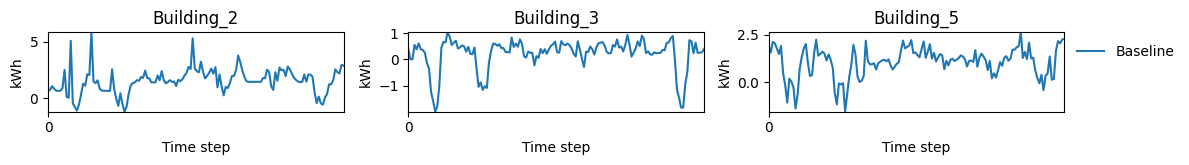

Building-level daily-average load profiles:


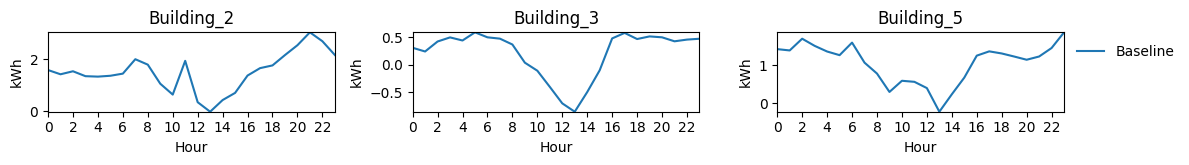

Battery SoC profiles:


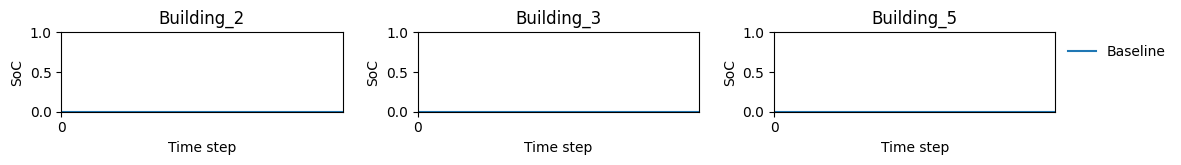

######## DISTRICT-LEVEL ########
District-level KPIs:


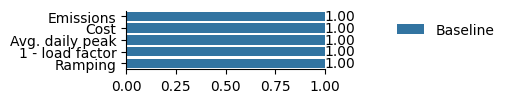

District-level simulation period load profiles:


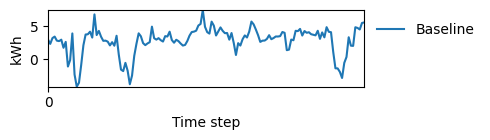

District-level daily-average load profiles:


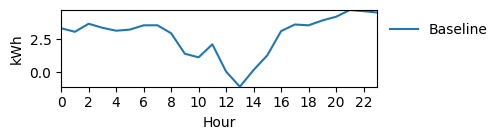

In [31]:
plot_simulation_summary({
    'Baseline': baseline_env,
})

## SAC Simulation

### Custom Reward Definiton


#### Base case reward
The goal is to reduce the electricty price paid for the energy

In [ ]:
class CustomReward(RewardFunction):
    def __init__(self, env_metadata: dict[str, Any]):
        r""" Initialize CustomReward

        Parameters
        ------
        env_metadata: dic[str, Any]:
        General static information about the environment.
        """
        super().__init__(env_metadata)

    def calculate(
        self, observations: list[dict[str,int | float]]
    ) -> list[float]:
        r"""Returns reward for most recent action.

        The reward is designed to minimize electricity cost.
        It is calculated for each building, i and summed to provide the agent
        with a reward that is representative of all n buildings.
        It encourages net-zero energy use by penalizing grid load satisfaction
        when there is energy in the battery as well as penalizing
        net export when the battery is not fully charged through the penalty
        term. There is neither penalty nor reward when the battery
        is fully charged during net export to the grid. Whereas, when the
        battery is charged to capacity and there is net import from the
        grid the penalty is maximized.

        Parameters
        ----------
        observations: list[dict[str, int | float]]
            List of all building observations at current
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            that are got from calling
            :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: list[float]
            Reward for transition to current timestep.
        """

        reward_list = []

        for o, m in zip(observations, self.env_metadata['buildings']):
            cost = o['net_electricity_consumption']*o['electricity_pricing']
            battery_soc = o['electrical_storage_soc']
            penalty = -(1.0 + np.sign(cost)*battery_soc)
            reward = penalty*abs(cost)
            reward_list.append(reward)

        reward = [sum(reward_list)]

        return reward

### Environment Creation

In [ ]:
sac_env= CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=TRAINING_START_TIME_STEP,
    simulation_end_time_step=TRAINING_END_TIME_STEP,
    reward_function=CustomReward,
    episode_time_steps=EPISODE_TIME_STEPS,
)

In [ ]:
# 1st Wrap to categorize all the observations in the interval [0,1]
sac_env = NormalizedObservationWrapper(sac_env)

# 2nd Wrap to b eable to use the pre-installed algorithms within StableBaselines3
sac_env = StableBaselines3Wrapper(sac_env)

print(sac_env.reset())

### Agent definition

#### Agent 1 definition
This agent will be trained using `model.learn()` without a loop

In [ ]:
# Inizialize the SAC MODEL
sac_model_1 = SAC(policy='MlpPolicy', env=sac_env, seed=RANDOM_SEED)

#### Agent 2 defintion
This agent will be trained using `model.learn()` with a loop.

In [ ]:
# Second model to compare training
sac_model_2 = SAC(policy='MlpPolicy', env=sac_env, seed=RANDOM_SEED)

### Training

### Consideration for the training on SB3.
There are two ways available for training with SB3.

1. `model.learn(total_timesteps = 30*24, reset_num_timesteps = False )` - In this case the total_timesteps are 720. If in the createiion of the citylearn environment the episode_timesteps are set to 24 the training will be done over the 30 episodes. The model won't run over the same 24 chunks as long as `reset_num_timesteps = False`.

2. `for _ in range(30):
        model.learn(total_timesteps=24, reset_num_timesteps=False)`

Is the same as before, It just feel more manual and gives controlo to insert logic between episodes.


**Some considerations**

a. Option 1 is almost always better because everytime `model.learn()` is called DB3 has to:
1. rebuild some training buffers;
2. reset parts of the rollout manager;
3. Re-run certain checks and initializations.

So with the loop this has to happen 30x more often wasting time.

b. SB3 algos store recent experiences in buffers (replay buffer for SAC, rollout buffer for PPO) across episodes.
In the 1st option the replay buffers fill coninously for 720 steps, giving the agent a richer, more varied pool of experiences to learn from in each gradient update.

In the 2nd option the buffer is only filled in tiny 24-steps burts, and in many cases, updates start from a much smaller set of experiences, which hurts tability

c. Better gradient updates.
For off-policy SAC algos like SA:
- Replay buffer can sample from * multiple episode at once* if it is kept alive.
- Calling `.learn()` in small chuncks still works (because `reset_num_timesteps = False`), but you're feeding the buffer in small trickles insted of a steady stream - less efficient for training.

d. Logging and learning rate schedules
SB3'S learning rate schedules and progrss meteres use the internal timestep counter.
- Option 1, scheduler sees smooth 0 --> 720 progression.
- Option 2, it still counts correctly if `reset_num_timesteps=Flase`, but logging and callbacks can trigger too frequently adding noise.


#### Episode check
This snap of code is meant to check the total episodes to run the algorithm and to define the `EPOCHS` for the second training method.

In [ ]:
sac_episodes = int(episodes)
sac_episode_timesteps = sac_env.unwrapped.time_steps
sac_total_timesteps = sac_episodes*sac_episode_timesteps

print(sac_episodes)
print(sac_episode_timesteps)
print(sac_total_timesteps)

# Ref without setting episode_time_steps = EPISODE_TIME_STEPS in env
# sac episodes:           30
# sac episodes timesteps: 720
# sac total timesteps:    21600
print(EPISODE_TIME_STEPS)

EPOCHS = 50
epochs = EPOCHS

#### Callback function to monitor the training phase

In [ ]:
class AverageRewardCallback(BaseCallback):
    def __init__(self, verbose=1):
        super().__init__(verbose)
        self.episode_rewards = []   # Stores total reward per episode
        self.current_reward = 0

    def _on_step(self) -> bool:
        # Accumulate rewards for the current episode
        self.current_reward += self.locals["rewards"][0]

        # When episode ends
        if self.locals["dones"][0]:
            self.episode_rewards.append(self.current_reward)
            avg_reward = np.mean(self.episode_rewards)
            if self.verbose > 0:
                print(f"Episode {len(self.episode_rewards)} | "
                      f"Reward: {self.current_reward:.2f} | "
                      f"Avg Reward: {avg_reward:.2f}")

            self.current_reward = 0  # reset for next episode

        return True

    def _on_training_end(self):
        if self.verbose > 0:
            print(f"\nTraining complete. Final Average Reward: {np.mean(self.episode_rewards):.2f}")

    def get_rewards(self):
        """Returns the list of episode rewards."""
        return self.episode_rewards

In [ ]:
### function to calculate the average reward per epoch
def average_epoch_reward(episode_rewards, epochs, episodes):
  average = []
  for ii in range(0, len(episode_rewards), episodes):
    chunk = episode_rewards[ii:ii+episodes]
    if chunk:
      average.append(sum(chunk)/len(chunk))
    else:
      average.append(0)
  return average


In [ ]:
# Callback to monitor the first training method
callback_1 = AverageRewardCallback(verbose=0)

# Callback to mintor the second training method
callback_2 = AverageRewardCallback(verbose=0)

#### Training Loop - Agent 1

In [ ]:
# How it was in the tutorial
# --- TRAIN THE MODEL ---
sac_env.reset()

start_time = time.perf_counter()
for epoch in tqdm(range(epochs)):
  ###
  # Reset dopo ogni epoca, ma tieni anche quello senza reset per vedere la differenza.
  ###
  for ii in (range(int(sac_episodes))):
    sac_model_1.learn(
        total_timesteps=sac_episode_timesteps,
        reset_num_timesteps=False,
        callback=callback_1,
  )
elapsed_big = time.perf_counter() - start_time
print("Agent 1 - Training Time: ", elapsed_big)

#### Training Loop - Agent 1a
The difference w.r.t. "Agent 1" is that afeter every Epoch the environment is reset.



In [ ]:
sac_env.reset()

start_time = time.perf_counter()
for epoch in tqdm(range(epochs)):
  ###
  # Reset dopo ogni epoca, ma tieni anche quello senza reset per vedere la differenza.
  ###
  sac_env.reset()
  for ii in (range(int(sac_episodes))):
    sac_model_1.learn(
        total_timesteps=sac_episode_timesteps,
        reset_num_timesteps=False,
        callback=callback_1,
  )
elapsed_big = time.perf_counter() - start_time
print("Agent 1 - Training Time: ", elapsed_big)

#### Training Loop - Agent 2

In [ ]:
# Theoretical Faster training
sac_env.reset()
start_time = time.perf_counter()
sac_model_2.learn(
      total_timesteps=sac_total_timesteps*epochs,
      reset_num_timesteps = False,
      callback=callback_2,
      )
elapsed_big = time.perf_counter() - start_time
print("Agent 2 - Training time: ", elapsed_big)
